<a href="https://colab.research.google.com/github/Tstrebe2/predicting-text-difficulty/blob/dave-updates/code/dave_feature_representations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
!pip install spacy
!python -m spacy download en_core_web_sm
!pip install spacy_readability

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.0 MB 5.1 MB/s 
  Created wheel for en-core-web-sm: filename=en_core_web_sm-2.3.1-py3-none-any.whl size=12047105 sha256=b1a9d7a8b3866b10321f3df5f72c96fe74617862880f44c3ce28576b76fa1386
  Stored in directory: /root/.cache/pip/wheels/b7/0d/f0/7ecae8427c515065d75410989e15e5785dd3975fe06e795cd9
Successfully built en-core-web-sm
  Attempting uninstall: en-core-web-sm
    Found existing installation: en-core-web-sm 3.4.0
    Uninstalling en-core-web-sm-3.4.0:
      Successfully uninstalled en-core-web-sm-3.4.0
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
import pandas as pd
import numpy as np
import spacy
from collections import Counter
from spacy_readability import Readability

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [9]:
nlp = spacy.load("en_core_web_sm")
# nlp.disable_pipes(['tok2vec', 'parser', 'attribute_ruler','ner'])
# nlp.add_pipe('sentencizer')
read = Readability()
# nlp.add_pipe('spacy_readability', last=True)
url = 'https://raw.githubusercontent.com/Tstrebe2/predicting-text-difficulty/main/assets/dale_chall.txt'
df = pd.read_csv(url,header=None, names=['word'])
dc_set = set(df['word'])



In [ ]:
!pip install spacy_readability

In [10]:
def D_ChallEvaluator(x,distinct=False):
  """
    function to evaluate what ratio of words for a given input 
    string are in Dale-Chall list

    Parameters
      x - str; the document to evaluate against Dale-Chall (D-C)
      distinct - boolean to determine whether each matching word counts once (True)
      or count each instance of a matching word (ie if the same dc word 
      appears twice or more)

    Returns 
      float representing the ratio of D-C words to total length of input 
      string
  """
  

  doc = nlp(x)
  
  # obtain the matched words between input str and the D-C set
  lemma_words = [token.lemma_ for token in doc]
  word_lst = set(lemma_words).intersection(dc_set)

  if distinct:
    # if we are interested in distinct words, just get the length of the set
    word_count = len(word_lst)

  else:  
    # if we look at instances, create a counter of matching D-C words and store
    # their frequencies.
    cntr = Counter([word for word in lemma_words if word in word_lst])
    
    # sum up all of the counts across the matching words
    word_count = np.sum([tup[1] for tup in cntr.items()])
  
  return word_count / len(x.split(' '))







In [11]:
train_url = 'https://raw.githubusercontent.com/Tstrebe2/predicting-text-difficulty/main/assets/WikiLarge_Train.csv'
train_df = pd.read_csv(train_url)

In [16]:
train_sample = train_df.sample(5000).copy()

train_sample.groupby('label').describe()


original_text                                                            \
              count unique                                                top   
label                                                                           
0              2503   2434  It is found in the region Basse-Normandie in t...   
1              2497   2484    Scroll down to edit the contents of this page .   

            
      freq  
label       
0       12  
1        3

In [26]:
train_sample = train_sample[['original_text','DC_Ratio',
                             'DC_Grade_level','label']]

In [18]:
# Call the custom built DChall Evaluator Function
train_sample["DC_Ratio"] = train_sample['original_text'].apply(lambda x: D_ChallEvaluator(x,False))

# This attempts to use the dale_chall algorithm built into the spacy readability module.
train_sample['DC_Grade_level'] = train_sample['original_text'].apply(lambda x: nlp(x)._.dale_chall)

In [45]:
train_sample['kincaid_level'] = train_sample['original_text'].apply(lambda x: nlp(x)._.flesch_kincaid_grade_level)
train_sample['kincaid_ease'] = train_sample['original_text'].apply(lambda x: nlp(x)._.flesch_kincaid_reading_ease)


In [19]:
import matplotlib.pyplot as plt


In [47]:
diff = train_sample[train_sample['label']==1]
easy = train_sample[train_sample['label']==0]

Mean Ratio for Difficult Text: 0.4648805697500309
Mean Ratio for Easy Text: 0.4706463447989345


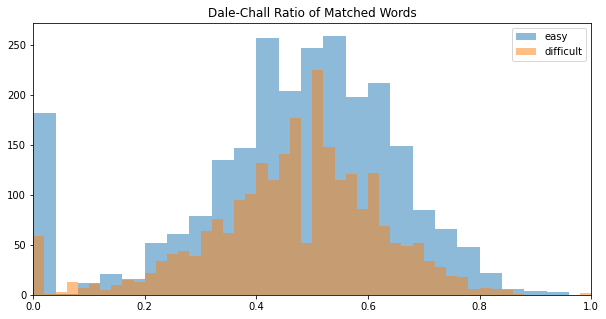

In [49]:


plt.figure(figsize=(10,5))
diff_mean = diff['DC_Ratio'].mean()
easy_mean = easy['DC_Ratio'].mean()
print(f"Mean Ratio for Difficult Text: {diff_mean}")
print(f"Mean Ratio for Easy Text: {easy_mean}")




plt.hist(easy['DC_Ratio'], 
         label='easy',
         alpha=0.5, bins=50)
plt.hist(diff['DC_Ratio'], 
         label='difficult',
         alpha=0.5, bins=50)

plt.legend(loc='upper right')
plt.title(f"Dale-Chall Ratio of Matched Words")
plt.xlim([0, 1])
plt.show()

Mean Grade_level for Difficult Text: 11.54
Mean Grade_level for Easy Text: 10.88


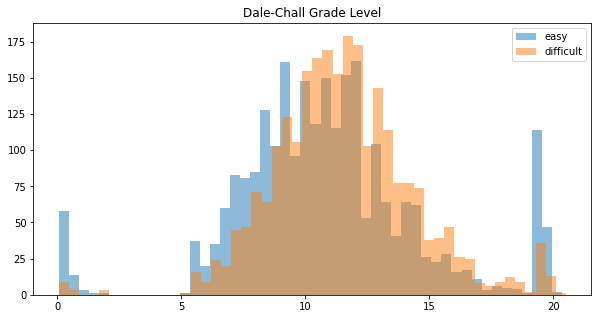

In [50]:
diff_mean = round(diff['DC_Grade_level'].mean(),2)
easy_mean = round(easy['DC_Grade_level'].mean(),2)
print(f"Mean Grade_level for Difficult Text: {diff_mean}")
print(f"Mean Grade_level for Easy Text: {easy_mean}")



plt.figure(figsize=(10,5))
plt.hist(easy['DC_Grade_level'], 
         label='easy',
         alpha=.5, bins=50)
plt.hist(diff['DC_Grade_level'], 
         label='difficult',
         alpha=0.5, bins=50)

plt.legend(loc='upper right')
plt.title("Dale-Chall Grade Level")

plt.show()

Kincaid Grade Level for Difficult Text: 11.29
Kincaid Grade Level for Easy Text: 8.59


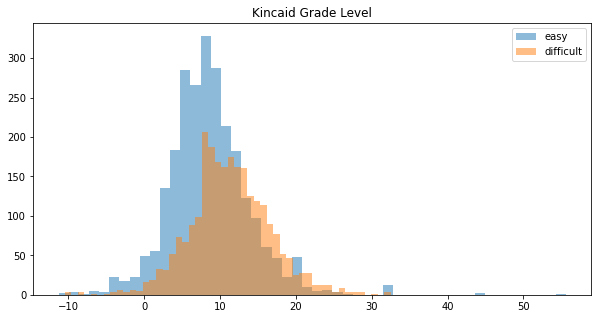

In [52]:
diff_mean = round(diff['kincaid_level'].mean(),2)
easy_mean = round(easy['kincaid_level'].mean(),2)
print(f"Kincaid Grade Level for Difficult Text: {diff_mean}")
print(f"Kincaid Grade Level for Easy Text: {easy_mean}")



plt.figure(figsize=(10,5))
plt.hist(easy['kincaid_level'], 
         label='easy',
         alpha=.5, bins=50)
plt.hist(diff['kincaid_level'], 
         label='difficult',
         alpha=0.5, bins=50)

plt.legend(loc='upper right')
plt.title("Kincaid Grade Level")

plt.show()

Kincaid Ease for Difficult Text: 50.26
Kincaid Ease for Easy Text: 58.77


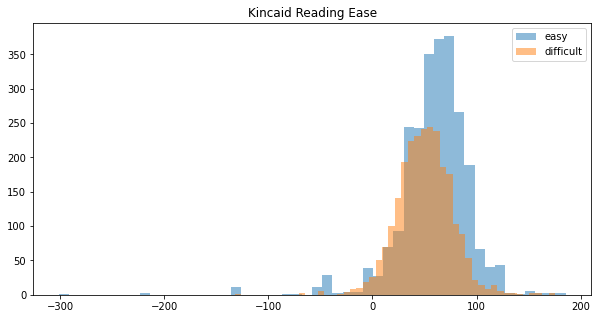

In [53]:
diff_mean = round(diff['kincaid_ease'].mean(),2)
easy_mean = round(easy['kincaid_ease'].mean(),2)
print(f"Kincaid Ease for Difficult Text: {diff_mean}")
print(f"Kincaid Ease for Easy Text: {easy_mean}")



plt.figure(figsize=(10,5))
plt.hist(easy['kincaid_ease'], 
         label='easy',
         alpha=.5, bins=50)
plt.hist(diff['kincaid_ease'], 
         label='difficult',
         alpha=0.5, bins=50)

plt.legend(loc='upper right')
plt.title("Kincaid Reading Ease")

plt.show()

In [35]:
# Sanity check to see if there were any cases where ratios exceeded 1 (which they shouldn't)
easy[easy['DC_Ratio']> 1]

,original_text,label,DC_Ratio,DC_Grade_level
217909,Middle-earth,0,2.0,0.0992


In [44]:
diff[diff['DC_Ratio'] > 1]

,original_text,label,DC_Ratio,DC_Grade_level
